# Interest-rate swaps

Copyright (&copy;) 2004, 2005, 2006, 2007 StatPro Italia srl

This file is part of QuantLib, a free-software/open-source library
for financial quantitative analysts and developers - https://www.quantlib.org/

QuantLib is free software: you can redistribute it and/or modify it under the
terms of the QuantLib license.  You should have received a copy of the
license along with this program; if not, please email
<quantlib-dev@lists.sf.net>. The license is also available online at
<https://www.quantlib.org/license.shtml>.

This program is distributed in the hope that it will be useful, but WITHOUT
ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
FOR A PARTICULAR PURPOSE.  See the license for more details.

In [34]:
import QuantLib as ql
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

### Global data

In [3]:
calendar = ql.TARGET()
todaysDate = ql.Date(6, ql.November, 2001)
ql.Settings.instance().evaluationDate = todaysDate
settlementDate = ql.Date(8, ql.November, 2001)

### Market quotes

In [4]:
deposits = {
    (3, ql.Months): 0.0363,
}

In [5]:
FRAs = {(3, 6): 0.037125, (6, 9): 0.037125, (9, 12): 0.037125}

In [6]:
futures = {
    ql.Date(19, 12, 2001): 96.2875,
    ql.Date(20, 3, 2002): 96.7875,
    ql.Date(19, 6, 2002): 96.9875,
    ql.Date(18, 9, 2002): 96.6875,
    ql.Date(18, 12, 2002): 96.4875,
    ql.Date(19, 3, 2003): 96.3875,
    ql.Date(18, 6, 2003): 96.2875,
    ql.Date(17, 9, 2003): 96.0875,
}

In [7]:
swaps = {
    (2, ql.Years): 0.037125,
    (3, ql.Years): 0.0398,
    (5, ql.Years): 0.0443,
    (10, ql.Years): 0.05165,
    (15, ql.Years): 0.055175,
}

We'll convert them to `Quote` objects...

In [8]:
for n, unit in deposits.keys():
    deposits[(n, unit)] = ql.SimpleQuote(deposits[(n, unit)])
for n, m in FRAs.keys():
    FRAs[(n, m)] = ql.SimpleQuote(FRAs[(n, m)])
for d in futures.keys():
    futures[d] = ql.SimpleQuote(futures[d])
for n, unit in swaps.keys():
    swaps[(n, unit)] = ql.SimpleQuote(swaps[(n, unit)])

...and build rate helpers.

In [9]:
dayCounter = ql.Actual360()
settlementDays = 2
depositHelpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(deposits[(n, unit)]),
        ql.Period(n, unit),
        settlementDays,
        calendar,
        ql.ModifiedFollowing,
        False,
        dayCounter,
    )
    for n, unit in deposits.keys()
]

In [10]:
dayCounter = ql.Actual360()
settlementDays = 2
fraHelpers = [
    ql.FraRateHelper(
        ql.QuoteHandle(FRAs[(n, m)]), n, m, settlementDays, calendar, ql.ModifiedFollowing, False, dayCounter
    )
    for n, m in FRAs.keys()
]

In [11]:
dayCounter = ql.Actual360()
months = 3
futuresHelpers = [
    ql.FuturesRateHelper(
        ql.QuoteHandle(futures[d]),
        d,
        months,
        calendar,
        ql.ModifiedFollowing,
        True,
        dayCounter,
        ql.QuoteHandle(ql.SimpleQuote(0.0)),
    )
    for d in futures.keys()
]

The discount curve for the swaps will come from elsewhere. A real application would use some kind of risk-free curve; here we're using a flat one for convenience.

In [12]:
discountTermStructure = ql.YieldTermStructureHandle(
    ql.FlatForward(settlementDate, 0.04, ql.Actual360()))

In [13]:
settlementDays = 2
fixedLegFrequency = ql.Annual
fixedLegTenor = ql.Period(1, ql.Years)
fixedLegAdjustment = ql.Unadjusted
fixedLegDayCounter = ql.Thirty360()
floatingLegFrequency = ql.Quarterly
floatingLegTenor = ql.Period(3, ql.Months)
floatingLegAdjustment = ql.ModifiedFollowing
swapHelpers = [
    ql.SwapRateHelper(
        ql.QuoteHandle(swaps[(n, unit)]),
        ql.Period(n, unit),
        calendar,
        fixedLegFrequency,
        fixedLegAdjustment,
        fixedLegDayCounter,
        ql.Euribor3M(),
        ql.QuoteHandle(),
        ql.Period("0D"),
        discountTermStructure,
    )
    for n, unit in swaps.keys()
]

### Term structure construction

In [14]:
forecastTermStructure = ql.RelinkableYieldTermStructureHandle()

In [15]:
helpers = depositHelpers + futuresHelpers + swapHelpers[1:]
depoFuturesSwapCurve = ql.PiecewiseFlatForward(settlementDate, helpers, ql.Actual360())

In [16]:
helpers = depositHelpers + fraHelpers + swapHelpers
depoFraSwapCurve = ql.PiecewiseFlatForward(settlementDate, helpers, ql.Actual360())

### Experiment

In [39]:
data = [(d.to_date(), r) for d, r in depoFuturesSwapCurve.nodes()]
swapCurve = pd.DataFrame(data, columns=['date', 'rate'])
swapCurve

,date,rate
0,2001-11-08,0.036133
1,2002-02-08,0.036133
2,2002-03-19,0.038028
3,2002-06-20,0.031994
4,2002-09-19,0.029988
5,2002-12-18,0.033020
6,2003-03-18,0.034972
7,2003-06-19,0.035959
8,2003-09-18,0.036961
9,2003-12-17,0.038955


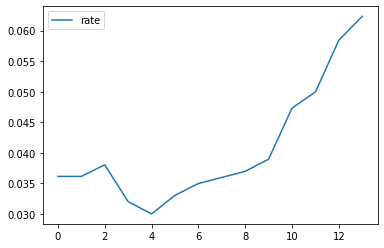

In [40]:
swapCurve.plot()

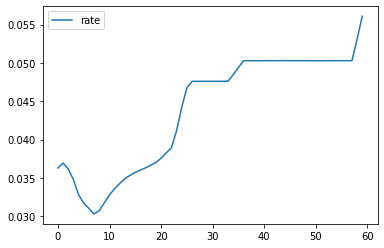

In [58]:
data = []
for i in range(60):
    dt = calendar.advance(depoFuturesSwapCurve.referenceDate(), i, ql.Months)
    rate = depoFuturesSwapCurve.forwardRate(dt, calendar.advance(dt, 3, ql.Months), ql.Actual360(), ql.Simple).rate()
    data.append((dt.to_date(), rate))
    
pd.DataFrame(data, columns=['date', 'rate']).plot()

In [56]:
depoFuturesSwapCurve.referenceDate()

Date(8,11,2001)